## **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt 
import itertools

from gensim.utils import lemmatize

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

# keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [ ]:
!pip install pattern

     |████████████████████████████████| 22.3MB 1.6MB/s 
     |████████████████████████████████| 92kB 8.7MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 5.6MB 44.8MB/s 
     |████████████████████████████████| 5.5MB 34.8MB/s 
     |████████████████████████████████| 419kB 45.6MB/s 
     |████████████████████████████████| 3.2MB 37.5MB/s 
     |████████████████████████████████| 102kB 9.6MB/s 
  Created wheel for pattern: filename=Pattern-3.6-cp37-none-any.whl size=22332724 sha256=f0db377adaba0bcb59e55a4046495d9b7d6cb2dc61a6dd123274ad5d886b0ccb
  Stored in directory: /root/.cache/pip/wheels/dc/9a/0e/5fb1a603ed4e3aa8722a88e9cf4a82da7d1b63e3d2cc34bee5
  Created wheel for mysqlclient: filename=mysqlclient-2.0.3-cp37-cp37m-linux_x86_64.whl size=100104 sha256=a5d7fa7d5b24c5f4abb4ad17d3ca36e5ddf007530c234d5739a5754d8d904fe0
  Stored in directory: /root/.cache/pip/wheels/75/ca/e8/ad4e7ce3df18bcd91c7d84dd28c7c08db491a2a2360efed363
  Created wheel f

## **Loading the Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Corpus = pd.read_csv("drive/MyDrive/Dataset_Sentiment/amazon_reviews.csv",encoding='latin-1')

In [ ]:
Corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    1000 non-null   object
 1   Polarity  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [ ]:
Corpus.head(2)

,Review,Polarity
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1


## **1. Data Pre-processing**
This will help in getting better results through the classification algorithms

### **1.1 Convert the text to lower case**
This is required as python interprets 'text', 'Text' and 'TEXT' differently.

In [ ]:
Corpus['Review'] = [text.lower() for text in Corpus['Review']]

In [ ]:
Corpus['Review'].head(2)

0    so there is no way for me to plug it in here i...
1                          good case, excellent value.
Name: Review, dtype: object

### **1.2 Text Lemmatization**

In [ ]:
for index,text in enumerate(Corpus['Review']):
  
  lem_sen = [word.decode('utf-8').split('/')[0] for word in lemmatize(text)]

  Corpus.loc[index,'review_words'] = str(lem_sen)

In [ ]:
Corpus['review_words'].head()

0     ['be', 'way', 'plug', 'here', 'go', 'converter']
1               ['good', 'case', 'excellent', 'value']
2                                 ['great', 'jawbone']
3    ['tie', 'charger', 'conversation', 'last', 'mo...
4                               ['mic', 'be', 'great']
Name: review_words, dtype: object

## **2. Split the model into Train, Val and Test Dataset**

In [ ]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['review_words'],Corpus['Polarity'],test_size=0.4, random_state=123)

Test_X, Val_X, Test_Y, Val_Y = model_selection.train_test_split(Test_X, Test_Y, test_size=0.5, random_state=123)

## **3. Label encode the target variable**  
This is done to transform Categorical data of string type in the data set into numerical values

In [ ]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Val_Y = Encoder.fit_transform(Val_Y)
Test_Y = Encoder.fit_transform(Test_Y)

## **4. Vectorize the words by using TF-IDF Vectorizer** 
This is done to find how important a word in document is in comaprison to the corpus

In [ ]:
Tfidf_vect = TfidfVectorizer(decode_error='ignore')
Tfidf_vect.fit(Train_X)

TfidfVectorizer(analyzer='word', binary=False, decode_error='ignore',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Val_X_Tfidf = Tfidf_vect.transform(Val_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
Train_X_Tfidf

<600x1054 sparse matrix of type '<class 'numpy.float64'>'
	with 3585 stored elements in Compressed Sparse Row format>

In [ ]:
TrainX = np.asarray(Train_X_Tfidf.todense())
ValX = np.asarray(Val_X_Tfidf.todense())
TestX = np.asarray(Test_X_Tfidf.todense())

In [ ]:
TrainX.dtype, ValX.dtype, TestX.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

In [ ]:
TrainX.shape, ValX.shape, TestX.shape

((600, 1054), (200, 1054), (200, 1054))

## **5. Review Classification Algorithm- ANN**

In [ ]:
ip_dim = TrainX.shape[1]
ip_dim

1054

### **5.1 Build network and train it untill validation loss reduces (EarlyStopping)**

In [ ]:
model1 = Sequential()
model1.add(Dense(64, input_dim=ip_dim, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
# compiling model using Adam optimizer
opt = Adam(lr=1e-3)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics= ['accuracy'])

In [ ]:
# fitting model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adam = model1.fit(TrainX, np.asarray(Train_Y), batch_size=100, epochs=30, verbose = 2, validation_data=(ValX, np.asarray(Val_Y)), callbacks= callbacks) 

Epoch 1/30
6/6 - 1s - loss: 0.6923 - accuracy: 0.5133 - val_loss: 0.6903 - val_accuracy: 0.5600
Epoch 2/30
6/6 - 0s - loss: 0.6821 - accuracy: 0.7133 - val_loss: 0.6860 - val_accuracy: 0.6300
Epoch 3/30
6/6 - 0s - loss: 0.6708 - accuracy: 0.8317 - val_loss: 0.6792 - val_accuracy: 0.6800
Epoch 4/30
6/6 - 0s - loss: 0.6550 - accuracy: 0.8933 - val_loss: 0.6688 - val_accuracy: 0.6900
Epoch 5/30
6/6 - 0s - loss: 0.6324 - accuracy: 0.9267 - val_loss: 0.6544 - val_accuracy: 0.7250
Epoch 6/30
6/6 - 0s - loss: 0.6020 - accuracy: 0.9450 - val_loss: 0.6340 - val_accuracy: 0.7450
Epoch 7/30
6/6 - 0s - loss: 0.5614 - accuracy: 0.9600 - val_loss: 0.6079 - val_accuracy: 0.7600
Epoch 8/30
6/6 - 0s - loss: 0.5115 - accuracy: 0.9700 - val_loss: 0.5758 - val_accuracy: 0.7700
Epoch 9/30
6/6 - 0s - loss: 0.4521 - accuracy: 0.9783 - val_loss: 0.5400 - val_accuracy: 0.7850
Epoch 10/30
6/6 - 0s - loss: 0.3875 - accuracy: 0.9867 - val_loss: 0.5011 - val_accuracy: 0.7900
Epoch 11/30
6/6 - 0s - loss: 0.3210 - a

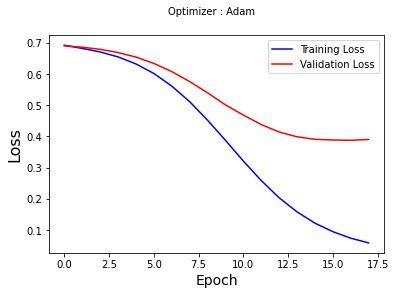

In [ ]:
#plotting Loss
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

### **5.2 Predict on Test data**

In [ ]:
pred_train = model1.predict(TrainX)
pred_test = model1.predict(TestX)
pred_val = model1.predict(ValX)

In [ ]:
AUC = np.array([roc_auc_score(Train_Y, pred_train),
                roc_auc_score(Val_Y, pred_val),
                roc_auc_score(Test_Y, pred_test)])
AUC

array([1.        , 0.90616459, 0.91162046])

In [ ]:
fpr, tpr, thresholds = roc_curve(Test_Y, pred_test)

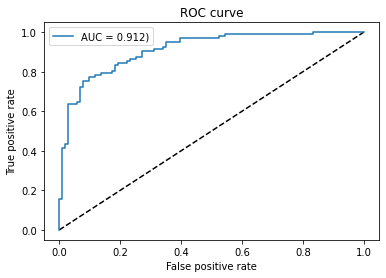

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f})'.format(AUC[2]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [ ]:
test_pred = (pred_test > 0.5).astype("int32").ravel()

In [ ]:
cm = confusion_matrix(y_true= Test_Y, y_pred=test_pred)
plot_labels = [0,1]

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], fontsize= 'xx-large',
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

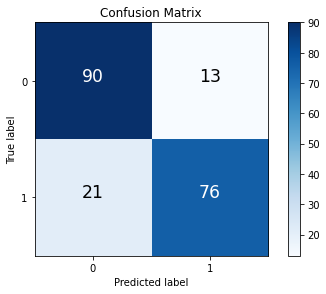

In [ ]:
plot_confusion_matrix(cm=cm, classes=plot_labels, title='Confusion Matrix')

In [ ]:
print( "Accuracy -> ", accuracy_score(Test_Y, test_pred), 
       "\nPrecision -> ", precision_score(Test_Y, test_pred),
       "\nRecall -> ", recall_score(Test_Y, test_pred),
       "\nF1-Score -> ", f1_score(Test_Y, test_pred))

Accuracy ->  0.83 
Precision ->  0.8539325842696629 
Recall ->  0.7835051546391752 
F1-Score ->  0.8172043010752688
